<a href="https://colab.research.google.com/github/codeguy234/4410Homework/blob/main/PretrainedPetEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cuda
Classes (37): ['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay'] ...
Splits -> train: 3312 val: 368 test: 3669
Parameters: 75,813 / Total: 23,583,845
Epoch 01 | train 0.5945 | val 0.8832 | tl 1.9782 vl 0.8665
Epoch 02 | train 0.8001 | val 0.9185 | tl 1.0750 vl 0.6976
Epoch 03 | train 0.8243 | val 0.9212 | tl 0.9793 vl 0.6627
Epoch 04 | train 0.8379 | val 0.9266 | tl 0.9391 vl 0.6266
Epoch 05 | train 0.8484 | val 0.9266 | tl 0.9148 vl 0.6205
Upload 3 pet photos (jpg or png)


Saving cat4.PNG to cat4 (7).PNG
Saving dog3.PNG to dog3 (8).PNG
Saving dog2.PNG to dog2 (8).PNG

PREDICTIONS


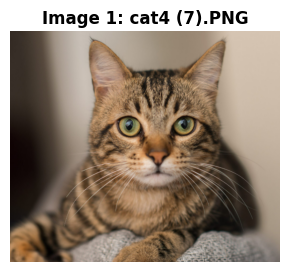

---------------------------------------------
Top 5 predictions:
  Bengal                    :  42.8%
  Maine Coon                :  40.6%
  Abyssinian                :   6.9%
  Egyptian Mau              :   2.2%
  Russian Blue              :   2.2%



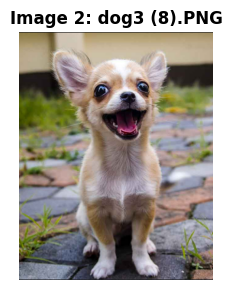

---------------------------------------------
Top 5 predictions:
  Chihuahua                 :  95.6%
  Pomeranian                :   2.6%
  Shiba Inu                 :   0.2%
  Scottish Terrier          :   0.2%
  Japanese Chin             :   0.1%



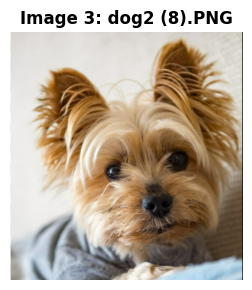

---------------------------------------------
Top 5 predictions:
  Yorkshire Terrier         :  96.3%
  Havanese                  :   0.5%
  Scottish Terrier          :   0.4%
  Pomeranian                :   0.3%
  Japanese Chin             :   0.2%



In [9]:
!pip -q install --upgrade torch torchvision torchaudio

import os, io, math, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files


seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

#Oxford-IIIT Pet
data_root = "./data"
base_ds = OxfordIIITPet(root=data_root, split="trainval", target_types="category", download=True)
classes = base_ds.classes
num_classes = len(classes)
print(f"Classes ({num_classes}):", classes[:8], "...")


weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

mean = getattr(preprocess, "mean", [0.485, 0.456, 0.406])
std  = getattr(preprocess, "std",  [0.229, 0.224, 0.225])

train_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Val/Test
val_tfms = preprocess
# -------------------------------------------------------------------------------

full_train = OxfordIIITPet(root=data_root, split="trainval", target_types="category",
                           download=True, transform=train_tfms)
full_val   = OxfordIIITPet(root=data_root, split="trainval", target_types="category",
                           download=True, transform=val_tfms)

n_total = len(full_train)
n_val = int(0.1 * n_total)
idxs = torch.randperm(n_total, generator=torch.Generator().manual_seed(seed))
val_idx, train_idx = idxs[:n_val], idxs[n_val:]
train_ds = Subset(full_train, train_idx)
val_ds   = Subset(full_val,   val_idx)

test_ds = OxfordIIITPet(root=data_root, split="test", target_types="category",
                        download=True, transform=val_tfms)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
print("Splits -> train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))


def build_resnet50(num_classes=37, freeze_backbone=True, which=ResNet50_Weights.DEFAULT):

    model = resnet50(weights=which)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
    if freeze_backbone:
        for p in model.parameters():
            p.requires_grad = False
        for p in model.fc.parameters():
            p.requires_grad = True
    return model

model = build_resnet50(num_classes=num_classes, freeze_backbone=True,
                       which=ResNet50_Weights.DEFAULT).to(device)
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Parameters: {trainable:,} / Total: {total:,}")

#validate
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total   += x.size(0)
    return total_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = loss_fn(logits, y)
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total   += x.size(0)
    return total_loss/total, correct/total

optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=3e-3, weight_decay=1e-4)
loss_fn   = nn.CrossEntropyLoss(label_smoothing=0.05)

EPOCHS = 5
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, loss_fn)
    va_loss, va_acc = evaluate(model, val_loader,   loss_fn)
    print(f"Epoch {ep:02d} | train {tr_acc:.4f} | val {va_acc:.4f} | tl {tr_loss:.4f} vl {va_loss:.4f}")

weights_inf = ResNet50_Weights.DEFAULT
preprocess_inf = weights_inf.transforms()

model.eval()
idx_to_class = dict(enumerate(classes))

@torch.no_grad()
def topk_predict(pil_img, k=5):
    img_transformed = preprocess_inf(pil_img).unsqueeze(0).to(device)  #pipeline
    logits = model(img_transformed)
    probs = logits.softmax(dim=1).squeeze(0).cpu().numpy()
    top_idx = probs.argsort()[::-1][:k]
    return [(idx_to_class[i], float(probs[i])) for i in top_idx]

def interpret_top(top):
    if not top: return "No prediction."
    (t1, p1) = top[0]

    return f"Top-1: {t1} ({p1*100:.1f}%). "

print("Upload 3 pet photos (jpg or png)")
uploaded = files.upload()

file_list = list(uploaded.items())
if len(file_list) != 3:
    print(f"{len(file_list)}. Upload 3 pet images.")
else:
    # Process all 3 images
    images = []
    predictions = []

    for fname, data in file_list:
        img = Image.open(io.BytesIO(data)).convert("RGB")
        images.append((fname, img))
        top = topk_predict(img, k=5)
        predictions.append(top)


    print("\n" + "="*50)
    print("PREDICTIONS")
    print("="*50)

    for i, (fname, img) in enumerate(images):
        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image {i+1}: {fname}", fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()

        print("-" * 45)
        print("Top 5 predictions:")
        for label, p in predictions[i]:
            print(f"  {label:25s} : {p*100:5.1f}%")

        print()

    print("="*50)